In [136]:
setwd("/projects/CARDIPS/analysis/epigenome_resource")
source("analyses/jennifer/notebooks/functions.R")

set.seed(5366)

# Figure 5d: Enrichment of Fetal-unique QTLs for GWAS colocalization

## read Supplemental Table for GWAS Colocalization

In [24]:
gwas_coloc = fread("manuscript/tables/Table_SX_GWAS_Colocalizations.txt", data.table = F) %>% 
    mutate(GWAS_ID = paste(GWAS_Index, Trait_Description, sep = "_"))
gwas_coloc$Element_Cond = ifelse(gwas_coloc$Element_Cond %like% "ENSG",
                                 paste(gwas_coloc$Tissue, gwas_coloc$Element_Cond, sep = "_"), 
                                 gwas_coloc$Element_Cond)

head(gwas_coloc,2)

,Tissue,Trait_Description,Trait_ID,Cluster_ID,QTL_Combination,Membership,Element_ID,Condition,Element_Cond,Element_Name,⋯,SE.GWAS,Pvalue.GWAS,99Credible_Set_Size,Colocalized,Has_TFBS,GWAS_Index,GWAS_QTL_Combination_Collapse,Fetal_Unique_QTL,Fetal_Unique_GWAS_Locus,GWAS_ID
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<int>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<chr>,<chr>
1,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_1059,caQTL-haQTL,Module,cvpc_chip_peak_9032,0,cvpc_chip_peak_9032_0,cvpc_chip_peak_9032,⋯,0.001687,0.870348,121,FALSE,FALSE,No Colocalization,No Colocalization,TRUE,No Colocalization,No Colocalization_Aging
2,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_1059,caQTL-haQTL,Module,cvpc_atac_peak_37717,0,cvpc_atac_peak_37717_0,cvpc_atac_peak_37717,⋯,0.001687,0.870348,166,FALSE,FALSE,No Colocalization,No Colocalization,TRUE,No Colocalization,No Colocalization_Aging


## read Supplemental Table for QTL Modules

In [5]:
mods = fread("/frazer01/home/tarthur/projects/Resource/SupplementalTables/TableS11_QTLModules.txt", data.table = F)
colnames(mods) = gsub(" ", "_", colnames(mods))
head(mods,2)

,Tissue,Cluster_ID,Element_ID,Condition,Molecular_QTL_Type,Membership,No._Colocalizations,No._QTLs_in_Module
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>
1,iPSC,iPSC_1,ipsc_atac_peak_17280,0,caQTL,Module,8,10
2,iPSC,iPSC_1,ipsc_atac_peak_17286,0,caQTL,Module,9,10


## read Supplemental Tables for QTLs

In [123]:
a = fread("manuscript/tables/Table_SX_caQTLs.txt", data.table = F) %>% select(Tissue, Element_ID, Element_Cond, Element_Name, Significant, Cluster_ID, Fetal_Unique) %>% mutate(Type = "caQTL")
b = fread("manuscript/tables/Table_SX_eQTLs.txt" , data.table = F) %>% select(Tissue, Element_ID, Element_Cond, Element_Name, Significant, Cluster_ID, Fetal_Unique) %>% mutate(Type = "eQTL") %>% mutate(Element_Cond = paste(Tissue, Element_Cond, sep = "_"))
c = fread("manuscript/tables/Table_SX_haQTLs.txt", data.table = F) %>% select(Tissue, Element_ID, Element_Cond, Element_Name, Significant, Cluster_ID, Fetal_Unique) %>% mutate(Type = "haQTL")

qtls = do.call(rbind, list(a, b, c))

head(qtls,2)

,Tissue,Element_ID,Element_Cond,Element_Name,Significant,Cluster_ID,Fetal_Unique,Type
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<chr>
1,CVPC,cvpc_atac_peak_10,cvpc_atac_peak_10_0,cvpc_atac_peak_10,FALSE,NA,NA,caQTL
2,CVPC,cvpc_atac_peak_100,cvpc_atac_peak_100_0,cvpc_atac_peak_100,FALSE,NA,NA,caQTL


## if a fetal-unique QTL is in the same module as an adult-shared QTL, then we considered it as adult-shared

In [127]:
qtls$Fetal_Unique_Cluster = ifelse(qtls$Cluster_ID %in% qtls[qtls$Fetal_Unique == F,]$Cluster_ID, F, T)

## how many were converted to adult-shared

In [128]:
table(qtls$Fetal_Unique, qtls$Fetal_Unique_Cluster)

       
        FALSE  TRUE
  FALSE 68700     0
  TRUE    236 10145

## label which qtls colocalized with a GWAS signals

In [129]:
qtls$Coloc_GWAS = ifelse(qtls$Element_Cond %in% gwas_coloc[gwas_coloc$Colocalized == T,]$Element_Cond, T, F)

In [130]:
table(qtls$Coloc_GWAS, qtls$Type)

       
         caQTL   eQTL  haQTL
  FALSE 582444  85391 128656
  TRUE     575    615    196

## remove qtls that were not tested for GWAS (i.e., did not have overlapping variants with GWAS)

In [131]:
qtls = qtls %>% filter(Element_Cond %in% gwas_coloc$Element_Cond)

## for fetal-unique QTLs that colocalized with GWAS loci that colocalized with shared QTLs, annotate them as non-fetal-unique

In [111]:
table(gwas_coloc$Fetal_Unique_GWAS_Locus)


            FALSE No Colocalization              TRUE 
             1717            264236                19 

In [113]:
a = gwas_coloc %>% filter(Fetal_Unique_GWAS_Locus == T)

In [116]:
length(unique(a$GWAS_ID))

[1] 17

In [118]:
qtls$Fetal_Unique_Cluster = ifelse(qtls$Element_Cond %in% a$Element_Cond, T, F)

## perform fisher test to calculate 

In [132]:
table(qtls$Coloc_GWAS, qtls$Fetal_Unique_Cluster)

       
        FALSE  TRUE
  FALSE 67235 10108
  TRUE   1363    23

In [133]:
test = fisher.test(table(qtls$Coloc_GWAS, qtls$Fetal_Unique_Cluster))
test


	Fisher's Exact Test for Count Data

data:  table(qtls$Coloc_GWAS, qtls$Fetal_Unique_Cluster)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.07087822 0.16924508
sample estimates:
odds ratio 
 0.1122452 


In [134]:
test$p.value

[1] 2.516571e-53

## create input for plotting

In [145]:
toplot = data.frame(table(qtls$Coloc_GWAS, qtls$Fetal_Unique_Cluster)) %>%
    group_by(Var2) %>%
    dplyr::mutate(total = sum(Freq)) %>%
    mutate(pct = Freq / total * 100) %>%
    mutate(label = paste0(Freq, ", ", signif(pct, 2), "%"))

# change columns
colnames(toplot)[1] = "Coloc_GWAS"
colnames(toplot)[2] = "Fetal_Unique_Cluster"

# convert column from factor to vector (needed to change labels, see next step)
toplot$Fetal_Unique_Cluster = as.vector(toplot$Fetal_Unique_Cluster)

# re-label
toplot[toplot$Fetal_Unique_Cluster == T,]$Fetal_Unique_Cluster = "Fetal-unique"
toplot[toplot$Fetal_Unique_Cluster == F,]$Fetal_Unique_Cluster = "Adult-shared"

toplot

Coloc_GWAS,Fetal_Unique_Cluster,Freq,total,pct,label
<fct>,<chr>,<int>,<int>,<dbl>,<chr>
FALSE,Adult-shared,67235,68598,98.013062,"67235, 98%"
TRUE,Adult-shared,1363,68598,1.986938,"1363, 2%"
FALSE,Fetal-unique,10108,10131,99.772974,"10108, 100%"
TRUE,Fetal-unique,23,10131,0.227026,"23, 0.23%"


## write source data

In [146]:
towrite = toplot %>% filter(Coloc_GWAS == T) %>%
    dplyr::rename(Total_Clusters = total) %>%
    dplyr::rename(Pct_Fetal_Unique_Cluster = pct) %>%
    dplyr::rename(Bar_Label = label) %>%
    dplyr::rename(N = Freq) %>%
    select(-Coloc_GWAS)

fwrite(towrite, "manuscript/figures/SourceData.Figure5d.FetalUnique_Enrichment.txt", row.names = F, sep = "\t")

## plot

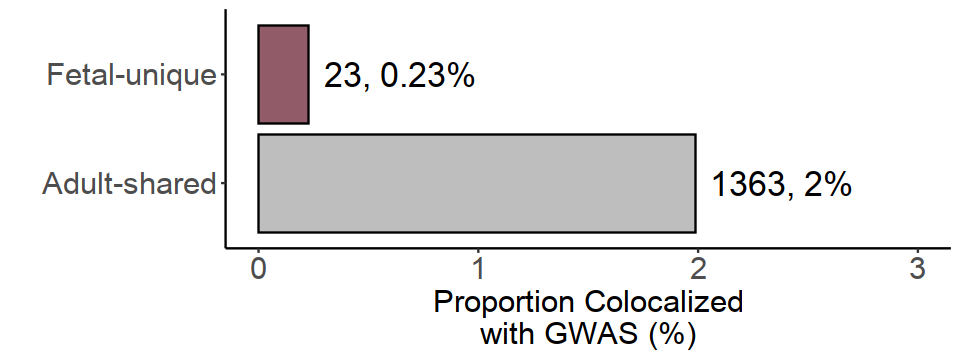

In [147]:
psize(w = 8, h = 3)
ggplot(towrite, aes(y = Fetal_Unique_Cluster, x = Pct_Fetal_Unique_Cluster, fill = Fetal_Unique_Cluster, label = Bar_Label)) + 
    geom_bar(stat = "identity", color = "black") + 
    jn_classic +  # personal theme
    scale_fill_manual(values = c("gray", "#915b68")) + 
    ylab("") + 
    theme(legend.position = "none") + 
    xlab("Proportion Colocalized\nwith GWAS (%)") + 
    geom_text(hjust = -0.1, size = 7) + 
    xlim(0, 3)